# Necessery modules

In [ ]:
! wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
! 7z e  fma_metadata.zip

! pip install spotdl

! sudo add-apt-repository ppa:jonathonf/ffmpeg-4
! sudo apt upgrade

! apt install ffmpeg

! git clone https://github.com/tyiannak/multimodalAnalysis.git

import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from subprocess import run
from shlex import split
import librosa
import IPython
from scipy import stats

--2022-06-15 18:17:16--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81M  18.8MB/s    in 19s     

2022-06-15 18:17:36 (18.2 MB/s) - ‘fma_metadata.zip’ saved [358412441/358412441]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 358412441 bytes (342 MiB)

Extracting archive: fma_metadata.zip
--
Path = fma_metadata.zip
Type = zip
Physical Size = 358412441

  0%      0% 4 - fma_metadata/

# Functions

In [ ]:
def track_download(Spotify_url):
  
  for file in os.listdir('/content/'):
    if file.endswith('mp3') or file.endswith('.wav'): 
      run(split('rm ' + file))
  

  run(split('spotdl ' + Spotify_url))
  run(split('python /content/multimodalAnalysis/audio/convertToWav.py /content 16000 1'))

def TrackFeatures():
  
  for file in os.listdir('/content/'):
    if file.endswith('.wav'):
      name = file
      file_name= os.path.join('/content', name)

  return compute_features(file_name)

def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()

def compute_features(track):

  features = pd.Series(index=columns())

  def feature_stats(name, values):
    features[name, 'mean'] = np.mean(values, axis=1)
    features[name, 'std'] = np.std(values, axis=1)
    features[name, 'skew'] = stats.skew(values, axis=1)
    features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
    features[name, 'median'] = np.median(values, axis=1)
    features[name, 'min'] = np.min(values, axis=1)
    features[name, 'max'] = np.max(values, axis=1)

  x, sr = librosa.load(track, sr=None, mono=True)  # kaiser_fast

  f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
  feature_stats('zcr', f)

  cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                           n_bins=7*12, tuning=None))
  assert cqt.shape[0] == 7 * 12
  assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

  f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
  feature_stats('chroma_cqt', f)
  f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
  feature_stats('chroma_cens', f)
  f = librosa.feature.tonnetz(chroma=f)
  feature_stats('tonnetz', f)

  del cqt
  stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
  assert stft.shape[0] == 1 + 2048 // 2
  assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
  del x

  f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
  feature_stats('chroma_stft', f)

  f = librosa.feature.rms(S=stft)
  feature_stats('rmse', f)

  f = librosa.feature.spectral_centroid(S=stft)
  feature_stats('spectral_centroid', f)
  f = librosa.feature.spectral_bandwidth(S=stft)
  feature_stats('spectral_bandwidth', f)
  f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
  feature_stats('spectral_contrast', f)
  f = librosa.feature.spectral_rolloff(S=stft)
  feature_stats('spectral_rolloff', f)

  mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
  del stft
  f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
  feature_stats('mfcc', f)

  return features

# <center>Machine learning in Multimedia Data<center>
# <center>MSc in Artificial Intelligence<center>
# <center>Spilios Dellis<center>

# Εισαγωγή

Στόχος της εργασίας αυτής είναι να δημιουργήσει μια μέθοδο βάση της οποίας δεδομένου ενός μουσικού κομματιού θα αναγνωρίζονται τα όμοια με αυτό μουσικά κομμάτια από μια λίστα Ν μουσικών κομματιών. Για το σκοπό αυτό θα χρησιμοποιηθεί ο kmeans αλγορίθμος βάση του οποίου τα μουσικά κομμάτια της λίστας χωρίζονται σε k συστάδες. Για την αναγνώριση των όμοιων κομματιών αρχικά το υπό μελέτη μουσικό κομμάτι θα καταχωρηθεί στην καταλληλότερη συστάδα και θα υπολογισθούν οι ευκλείδειες αποστάσεις μεταξύ αυτού και των υπόλοιπων μουσικών κομματιών της ίδιας συστάδας για να βρεθεί ο βαθμός ομοιότητας τους. Η μέθοδος αυτή επιλέχθηκε γιατί μειώνει τον αριθμό των μουσικών κομματιών που θα πρέπει να συγκριθούν ανά αναζήτηση. 

# Περιγραφή μεθόδου

## Δημιουργεία μοντέλου

 Η λίστα μουσικών κομματιών που χρησιμοποιήθηκε είναι η λίστα τραγουδιών της βάσης δεδομένων Free Music Archive (https://freemusicarchive.org/), Η βάση αυτή αποτελείται από 106574 τραγούδια τα οποία μπορούν να κατανεμηθούν σε 163 διαφορετικά είδη. Παράλληλα με τα μουσικά κομμάτια η βάση περιέχει csv αρχεία στα οποία υπάρχουν πληροφορίες για το κάθε κομμάτι αλλά και φασματικά χαρακτηριστικά του τα οποία έχουν εξαχθεί με την βιβλιοθήκη librossa. Τα χαρακτηριστικά αυτά θα χρησιμοποιηθούν για την κατάταξη των μουσικών κομματιών σε διαφορετικές συστάδες με την χρήση του kmeans αλγορίθμου. 

Συγκεκριμένα τα φασματικά χαρακτηριστικά τα οποία χρησιμοποιήθηκαν είναι οι στατιστικές τιμές των φασματικών χαρακτηριστικών υπολογισμένων για σταθερές χρονικές περιόδους στο κάθε μουσικό κομμάτι. Με τον τρόπο αυτό μπορούν να εξαχθούν 518 χαρακτηριστικά για το κάθε μουσικό κομμάτι ανεξάρτητα της χρονικής διάρκειάς του. 

In [ ]:
features = pd.read_csv('features.csv', skiprows = 4, header = None)
SpotifyFeat = pd.read_csv('echonest.csv', skiprows = 4, header = None)
SpotifyFeat = SpotifyFeat.drop([i for i in range(9, len(SpotifyFeat.columns))], axis = 1)
Tracks = pd.read_csv('raw_tracks.csv')

Προτού τα μουσικά κομμάτια κατανεμηθούν στις διάφορε συστάδες ο χώρος των χαρακτηριστικών μειώθηκε χρησιμοποιώντας την μέθοδο principal components analysis. Επιλέχθηκαν τόσοι principal components ώστε να μπορεί να περιγραφεί το 70 % του variance των παραδειγμάτων. 

In [ ]:
Features_data = features.drop(0, axis = 1)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(0.7))])
Features_Kmeans = pipe.fit_transform(Features_data)

Για την εύρεση του κατάλληλου αριθμού συστάδων στις οποίες χωρίσθηκαν τα μουσικά κομμάτια της λίστας χρησιμοποιήθηκε η μέθοδος elbow. Στην μέθοδο αυτή ένα μέγεθος το οποίο χαρακτηρίζει το σφάλμα της ομαδοποίησης υπολογίζεται για διαφορετικό αριθμό συστάδων. Ο βέλτιστος αριθμός συστάδων είναι αυτός για τον οποίο η μείωση ή η αύξηση του χαρακτηριστικού μεγέθους σταματάει να είναι ραγδαία. Στην παρακάτω εικόνα σχηματοποιείται η μέθοδος elbow. Στα πλαίσια της εργασίας χρησιμοποιήθηκε το distortion, η μέση τιμή του τετραγώνου της απόσταση των παραδειγμάτων από το κέντρο της συστάδας τους, σαν χαρακτηριστική τιμή του σφάλματος. 

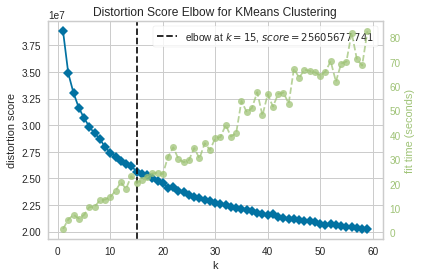

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,60))

visualizer.fit(Features_Kmeans)    
visualizer.show()

Όπως φαίνεται και από την παραπάνω εικόνα ο βέλτιστος αριθμός συστάδων είναι 16. Ο αριθμός τραγουδιών τα οποία ανήκουν στην κάθε συστάδα φαίνεται στην παρακάτω εικόνα. Η πλειοψηφία των συστάδων περιέχουν πάνω από 2000 μουσικά κομμάτια με μόνο 4 να έχουν λιγότερα από 20  

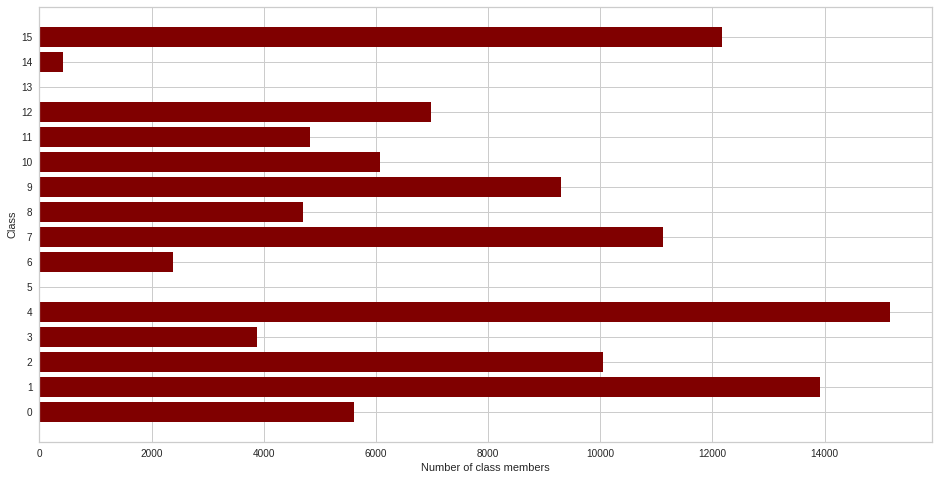

In [ ]:
Cluster_number = 16; Final_kmeanModel = KMeans(n_clusters=Cluster_number); Predictions = Final_kmeanModel.fit_predict(Features_Kmeans)

Class_pop = np.zeros(Cluster_number)
for i in range(len(Predictions)):
  Class_pop[Predictions[i]] += 1

Class = []
for i in range(Cluster_number):
  Class.append(str(i))

plt.figure(figsize=(16,8)); plt.barh(Class, Class_pop, color ='maroon'); plt.xlabel('Number of class members'); plt.ylabel('Class'); plt.show()

## Εύρεση όμοιων μουσικών κομματιών

Αρχικά το μουσικό κομμάτι το οποίο θέλουμε να συγκρίνουμε κατεβαίνει από το Spotify χρησιμοποιώντας το url του.


In [ ]:
Spotify_url = 'https://open.spotify.com/track/7MJQ9Nfxzh8LPZ9e9u68Fq?si=b49c3819397b4efe'
track_download(Spotify_url);

Το υπό μελέτη μουσικό κομμάτι μπορεί να αναπαραχθεί στο παρακάτω κελί.

In [ ]:
for file in os.listdir('/content/'):
  if file.endswith('.mp3'):
    name = file

IPython.display.Audio(name)

Output hidden; open in https://colab.research.google.com to view.

Στην συνέχεια υπολογίζονται τα φασματικά χαρακτηριστικά του υπό μελέτη κομματιού, μετασχηματίζονται βασιζόμενα στους μετασχηματισμούς που υπολογίστηκαν από τα παραδείγματα της λίστας και καταχρείται στην καταλληλότερη συστάδα. 

In [ ]:
Features_Track = TrackFeatures()
Feature_Track_Tr = pipe.transform(np.array(Features_Track).reshape(1, -1))
Track_class = Final_kmeanModel.predict(Feature_Track_Tr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Τέλος υπολογίζεται η ευκλείδεια απόσταση μεταξύ του υπό μελέτη μουσικού κομματιού και των υπόλοιπων της συστάδας στην οποία ανήκει. Βάση της απόστασης αυτής τα κομμάτια της λίστα κατατάσσονται κατά φθίνουσα τιμή. 

In [ ]:
listofrelevantsongs = []
for i in range(len(Predictions)):
  if Predictions[i] == Track_class[0]:
    listofrelevantsongs.append(i)

distances = []
for track in listofrelevantsongs:
  distances.append(distance.euclidean(Feature_Track_Tr, Features_Kmeans[track]))

yx = zip(distances, listofrelevantsongs)
sortedlistofrelevantsongs = [x for y,x in sorted(yx)]

Το μουσικό κομμάτι το οποίο παρουσιάζει την μεγαλύτερη ομοιότητα με το υπό μελέτη κομμάτι μπορεί να αναπαραχθεί στο επόμενο κελί. 

In [ ]:
Number = 0
TracksURL = Tracks['track_file'][Tracks['track_id']==features[0][sortedlistofrelevantsongs[Number]]].values[0].split('/')
track_url = os.path.join('wget https://files.freemusicarchive.org/storage-freemusicarchive-org/music/',  TracksURL[-4], TracksURL[-3], TracksURL[-2], TracksURL[-1])
run(split(track_url))
name = TracksURL[-1]
IPython.display.Audio(name)

# Σύνοψη

Στα πλαίσια της εργασίας δημιουργήθηκε μέθοδος μέσω της οποίας είναι δυνατόν, δεδομένου ενός μουσικού κομματιού, να αναγνωρισθούν από μια λίστα μουσικών κομματιών αυτά που παρουσιάζουν την μεγαλύτερη ομοιότητα με αυτό. Για το σκοπό αυτό χρησιμοποιήθηκε η βάση δεδομένων μουσικών κομματιών Free Music Archive.  

 
 

Συγκεκριμένα χρησιμοποιήθηκαν φασματικά χαρακτηριστικά των μουσικών κομματιών της λίστας για της οποίες, αφού υπολογίστηκαν για σταθερά χρονικά διαστήματα, υπολογίστηκαν στατιστικές παράμετροι για το σύνολο του κάθε κομματιού. Για το κάθε μουσικό κομμάτι της λίστας υπολογίστηκαν 518 χαρακτηρίστηκα. Τα μουσικά κομμάτια της λίστας χωρίστηκαν σε συστάδες με την χρήση του kmeans αλγορίθμου αφού πρώτα ο χώρος των χαρακτηριστικών τους είχε μειωθεί με την μέθοδο principal components analysis.  

 
 

Για την εύρεση του μουσικού κομματιού της λίστας το οποίο παρουσιάζει την μεγαλύτερη ομοιότητα με το υπό μελέτη, αρχικά υπολογίζονταν τα χαρακτηριστικά του υπό μελέτη κομματιού, και κατηγοριοποιούταν σε μία από της συστάδες. Στην συνέχεια υπολογίζονται οι ευκλείδειες αποστάσεις μεταξύ αυτού και τω υπολοίπων μουσικών κομματιών και κατατάσσονται βάση αυτών. 

 